# Predictive Maintenance in Solar Power Systems

# Problem Statement: 
Solar power plants play a crucial role in the transition toward clean energy. However, maintaining large solar farms is challenging, as breakdowns or inefficiencies can significantly reduce power output and cause financial losses. Traditionally, maintenance schedules are set based on time intervals, which may lead to over-maintenance or under-maintenance of equipment. The introduction of AI-driven predictive maintenance offers a solution that can help identify potential failures before they happen.

# Dataset:

https://www.kaggle.com/datasets/anikannal/solar-power-generation-data?datasetId=836676&sortBy=voteCount&select=Plant_1_Generation_Data.csv
https://www.kaggle.com/datasets/anikannal/solar-power-generation-data?datasetId=836676&sortBy=voteCount&select=Plant_1_Weather_Sensor_Data.csv
https://www.kaggle.com/datasets/anikannal/solar-power-generation-data?datasetId=836676&sortBy=voteCount&select=Plant_2_Generation_Data.csv
https://www.kaggle.com/datasets/anikannal/solar-power-generation-data?datasetId=836676&sortBy=voteCount&select=Plant_2_Weather_Sensor_Data.csv

# Load required library

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import warnings

# Load Generation Data (Plant 1)

In [21]:
gen_data = pd.read_csv('/Users/tech/Documents/Jupyter Notebook/DataSet/SolarPower/Plant_2_Generation_Data.csv')
weather_data = pd.read_csv('/Users/tech/Documents/Jupyter Notebook/DataSet/SolarPower/Plant_2_Weather_Sensor_Data.csv')

# Format 'DATE_TIME' column to datetime

In [23]:
gen_data['DATE_TIME'] = pd.to_datetime(gen_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# 1. Daily Yield & AC/DC Power from Generation Data

In [24]:
gen_data_daily = gen_data.set_index('DATE_TIME').resample('D').sum().reset_index()

# Plot Daily Yield and AC/DC Power

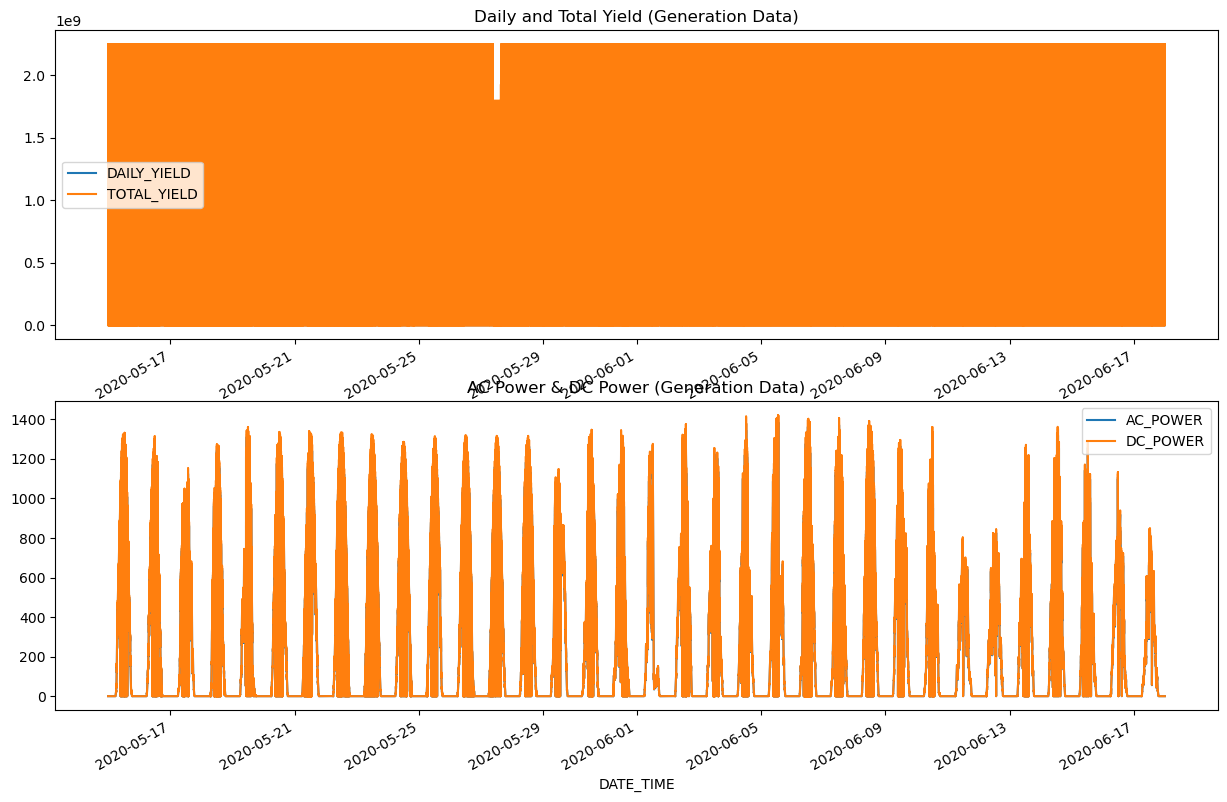

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
gen_data.plot(x='DATE_TIME', y=['DAILY_YIELD', 'TOTAL_YIELD'], ax=ax[0], title="Daily and Total Yield (Generation Data)")
gen_data.plot(x='DATE_TIME', y=['AC_POWER', 'DC_POWER'], ax=ax[1], title="AC Power & DC Power (Generation Data)")
plt.show()

### 2. Irradiation, Ambient and Module Temperature from Weather Data

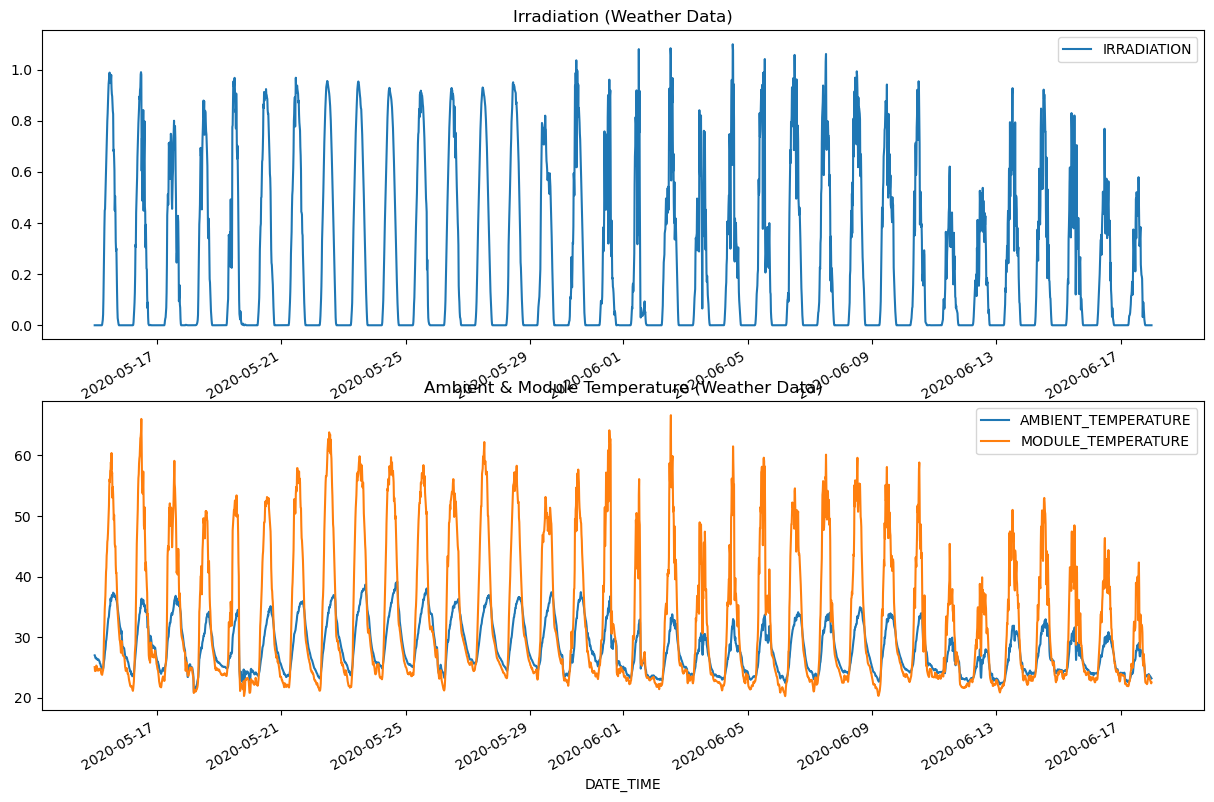

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
weather_data.plot(x='DATE_TIME', y='IRRADIATION', ax=ax[0], title="Irradiation (Weather Data)")
weather_data.plot(x='DATE_TIME', y=['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'], ax=ax[1], title="Ambient & Module Temperature (Weather Data)")
plt.show()

### 3. Real DC power converted (DC Power efficiency)

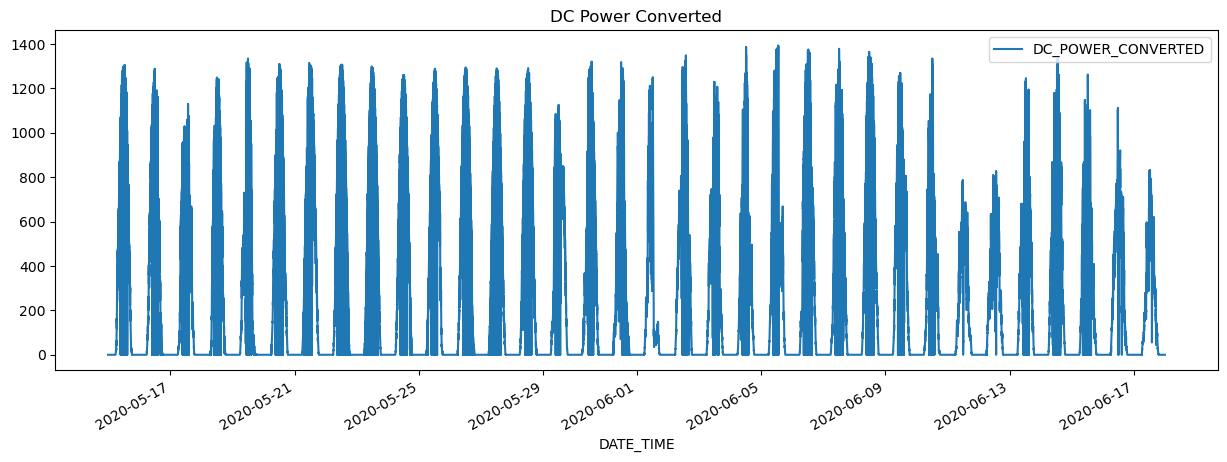

In [27]:
gen_data['DC_POWER_CONVERTED'] = gen_data['DC_POWER'] * 0.98  # Assume 2% loss in conversion
fig, ax = plt.subplots(figsize=(15, 5))
gen_data.plot(x='DATE_TIME', y='DC_POWER_CONVERTED', ax=ax, title="DC Power Converted")
plt.show()

### 4. DC Power generated during day hours (Generation Data)

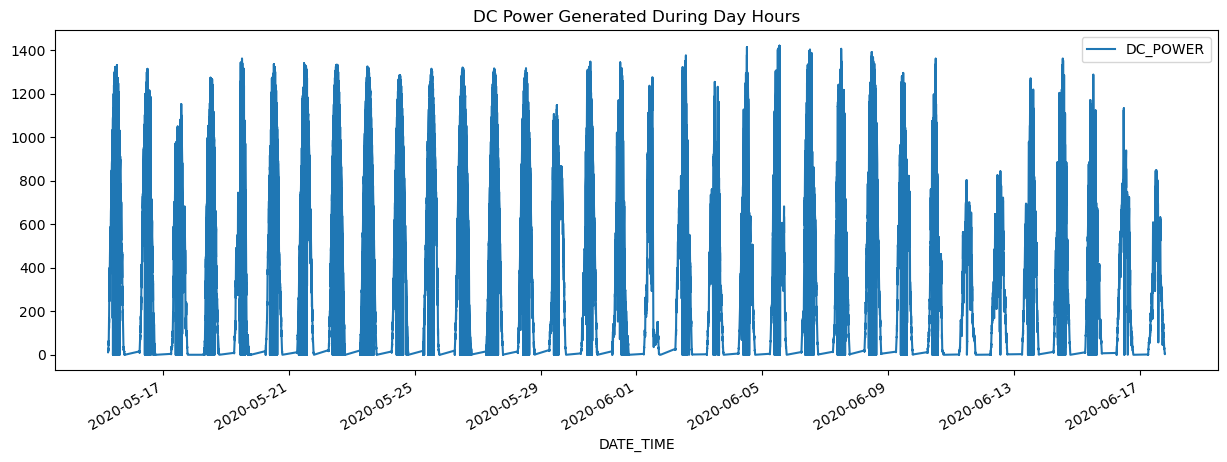

In [28]:
day_data_gen = gen_data[(gen_data['DATE_TIME'].dt.hour >= 6) & (gen_data['DATE_TIME'].dt.hour <= 18)]
fig, ax = plt.subplots(figsize=(15, 5))
day_data_gen.plot(x='DATE_TIME', y='DC_POWER', ax=ax, title="DC Power Generated During Day Hours")
plt.show()

### 5. Inverter Analysis (Generation Data)

In [29]:
inverter_performance = gen_data.groupby('SOURCE_KEY')['DC_POWER'].mean().sort_values()
print(f"Underperforming inverter: {inverter_performance.idxmin()}")

Underperforming inverter: Quc1TzYxW2pYoWX


### 6. Module temperature and Ambient Temperature on PLANT_1 (Weather Data)

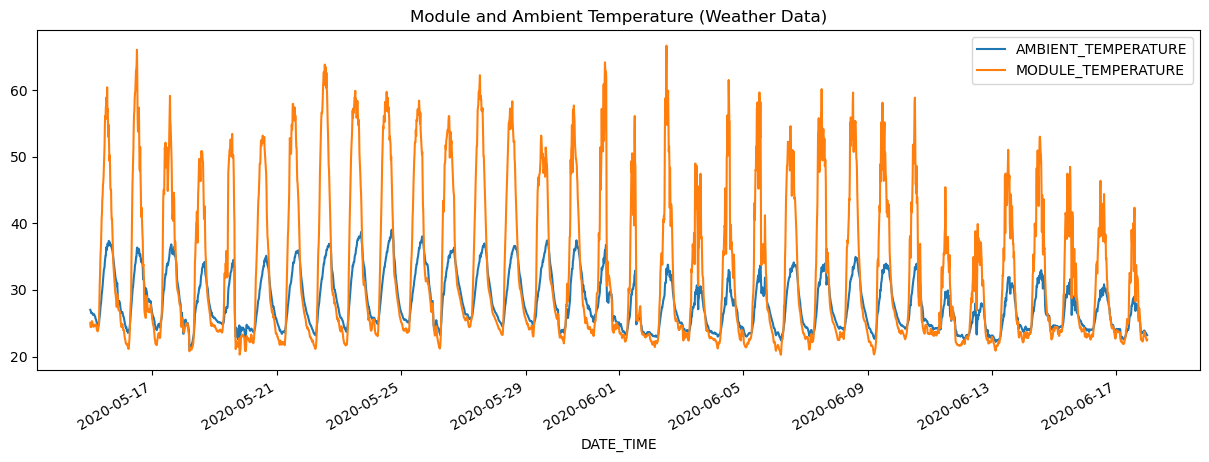

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
weather_data.plot(x='DATE_TIME', y=['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'], ax=ax, title="Module and Ambient Temperature (Weather Data)")
plt.show()

### 7. Inverter bvBOhCH3iADSZry in action (Generation Data)

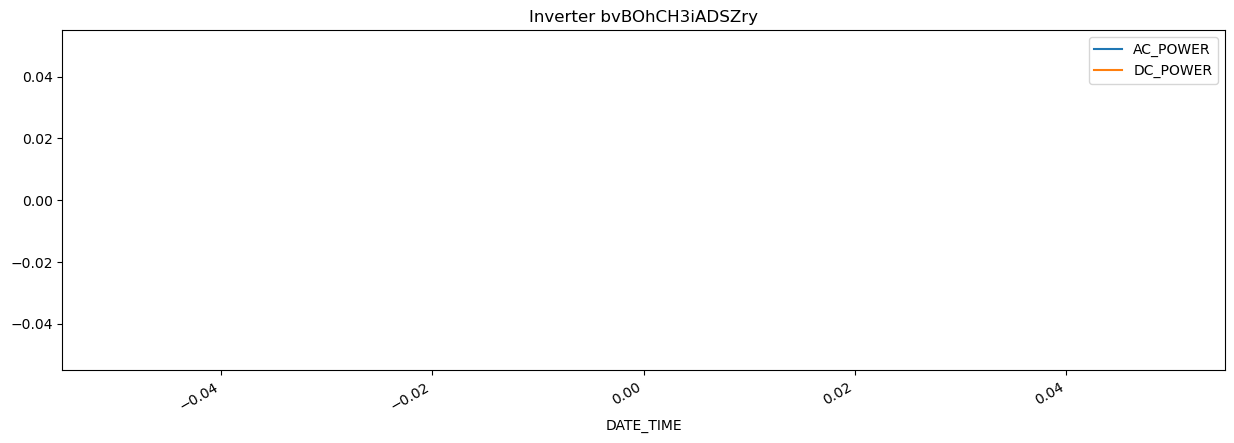

In [31]:
inverter_data = gen_data[gen_data['SOURCE_KEY'] == 'bvBOhCH3iADSZry']
fig, ax = plt.subplots(figsize=(15, 5))
inverter_data.plot(x='DATE_TIME', y=['AC_POWER', 'DC_POWER'], ax=ax, title="Inverter bvBOhCH3iADSZry")
plt.show()

### 8. Forecasting with ARIMA (Generation Data)

In [32]:
df_daily_gen = gen_data_daily[['DATE_TIME', 'DAILY_YIELD']].set_index('DATE_TIME')

# Testing for stationarity

In [33]:
result = adfuller(df_daily_gen['DAILY_YIELD'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.9557903431446046
p-value: 0.03923439833161665


# Splitting the dataset

In [34]:
train_gen, test_gen = train_test_split(df_daily_gen, test_size=0.2, shuffle=False)

# ARIMA model

In [35]:
arima_model_gen = ARIMA(train_gen['DAILY_YIELD'], order=(5, 1, 0))
arima_fit_gen = arima_model_gen.fit()
forecast_arima_gen = arima_fit_gen.forecast(steps=len(test_gen))
test_gen['Forecast_ARIMA'] = forecast_arima_gen

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# Plot ARIMA Forecast

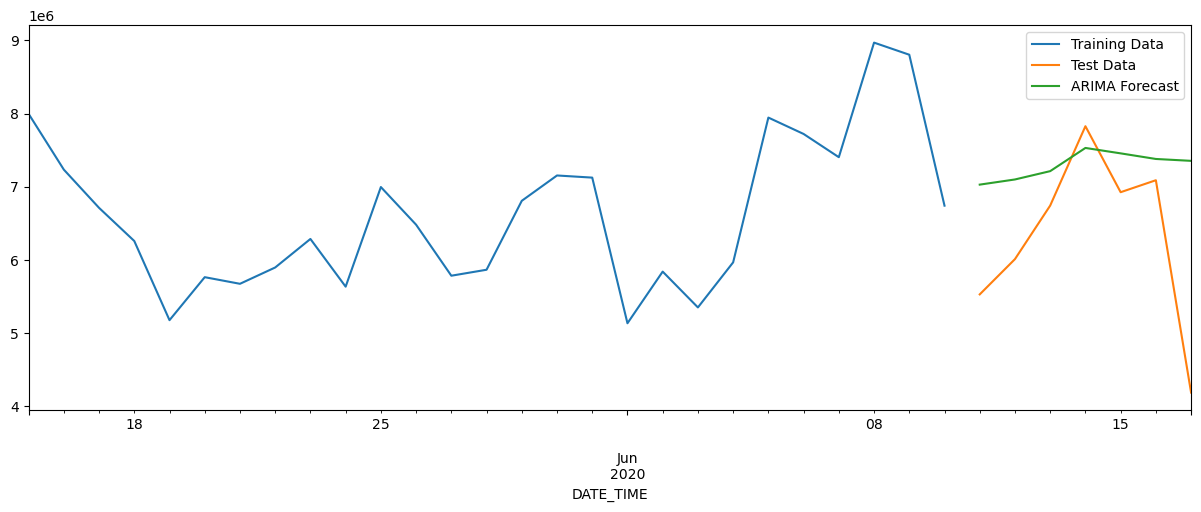

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
train_gen['DAILY_YIELD'].plot(ax=ax, label='Training Data')
test_gen['DAILY_YIELD'].plot(ax=ax, label='Test Data')
test_gen['Forecast_ARIMA'].plot(ax=ax, label='ARIMA Forecast')
plt.legend()
plt.show()

### 9. SARIMA Model for Seasonal Data (Alternative to Prophet)

In [37]:
sarima_model = SARIMAX(train_gen['DAILY_YIELD'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test_gen))
test_gen['Forecast_SARIMA'] = sarima_forecast

C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


# Plot SARIMA Forecast

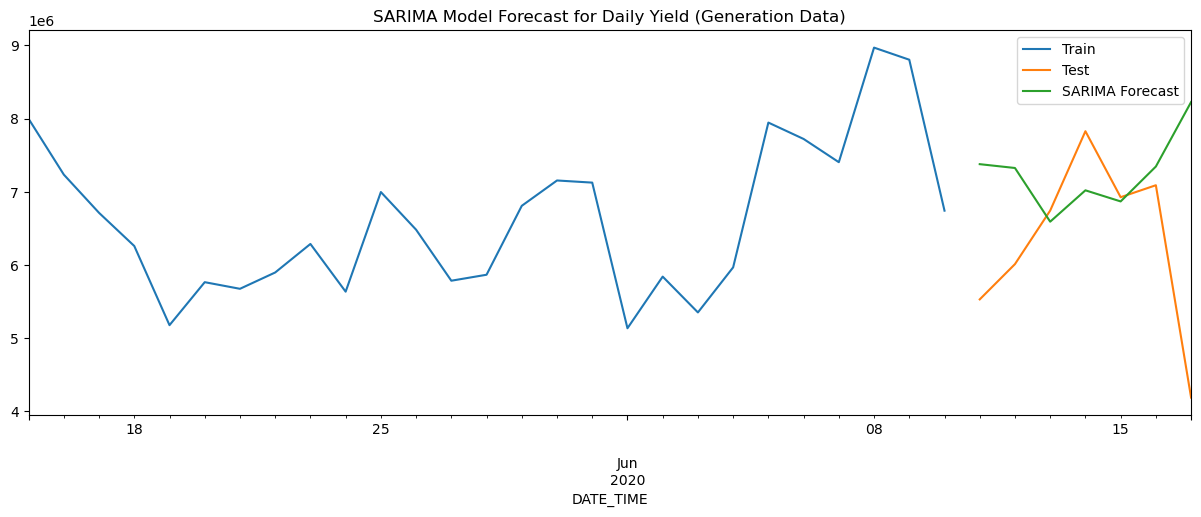

In [38]:
plt.figure(figsize=(15, 5))
train_gen['DAILY_YIELD'].plot(label='Train')
test_gen['DAILY_YIELD'].plot(label='Test')
test_gen['Forecast_SARIMA'].plot(label='SARIMA Forecast')
plt.legend()
plt.title('SARIMA Model Forecast for Daily Yield (Generation Data)')
plt.show()

### 10. SARIMAX vs ARIMA Comparison (Generation Data)

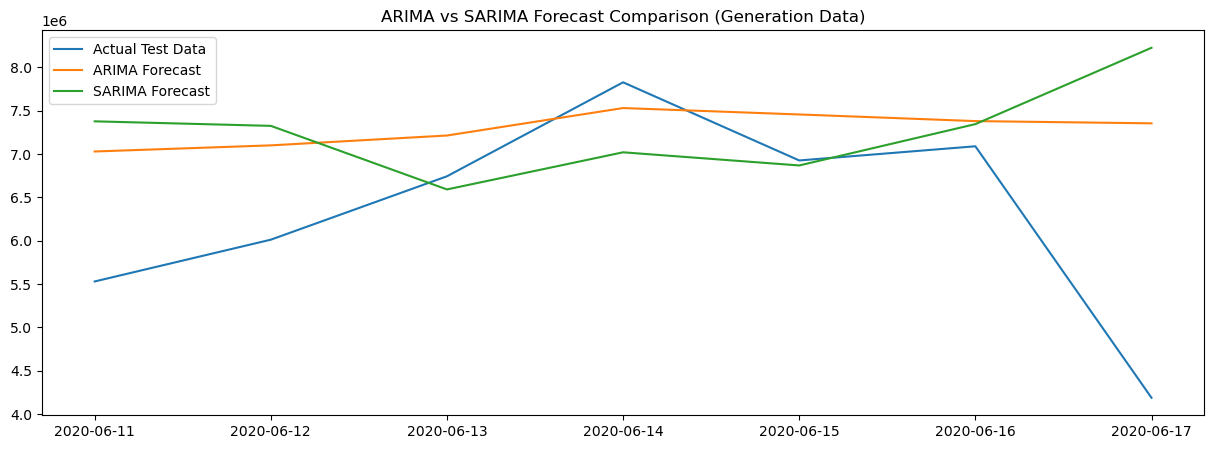

In [39]:
plt.figure(figsize=(15, 5))
plt.plot(test_gen.index, test_gen['DAILY_YIELD'], label='Actual Test Data')
plt.plot(test_gen.index, test_gen['Forecast_ARIMA'], label='ARIMA Forecast')
plt.plot(test_gen.index, test_gen['Forecast_SARIMA'], label='SARIMA Forecast')
plt.legend()
plt.title("ARIMA vs SARIMA Forecast Comparison (Generation Data)")
plt.show()